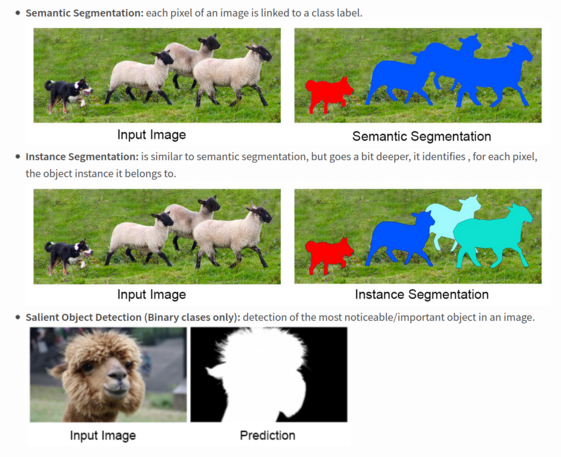


This will be a short notebook on how to train a **SemTorch** model using the competition's data. 

In the process, I will try to explain the different steps for those new to fastai in general and SemTorch in
particular.

Before we start, if you are new to **segmentation** in general, consider the following [notebook](https://www.kaggle.com/yassinealouini/all-the-segmentation-metrics) as well.

Let's go!


# SemTorch: what is it?

As you haved guessed it by now, **SemTorch** is a **segmentation library** based on **fastai**. 

It is made by **David Lacalle Castillo**. 


The main function that we will use later is `get_segmentation_learner`. To get it, you can 
import it using the following snippet:

`from semtorch import get_segmentation_learner`

This fucntion uses some if statements depending on the architecture chosen and then, mainly the fastai `Learner` class.


If you are curious, you can check the code source [here](https://github.com/WaterKnight1998/SemTorch/blob/develop/semtorch/learner.py#L81)


So in order to understand how it works, we first need to understand (a bit) how [fastai](https://github.com/fastai/fastai) works.

## A fastai detour

<img src="https://www.fast.ai/images/Fast.ai.png" width=480>

**fastai** is a deep learning library based on [PyTorch](https://pytorch.org/). 

I have done a previous notebook about fastai [here](https://www.kaggle.com/yassinealouini/learning-fastai-part-i) so this paragraph could be considered the long awaited part II. ;) 

For those that haven't checked part I, it introduces the notion of dataset in fastai: dataloaders.

https://docs.fast.ai/data.core.html

Here I will talk more specifically about the **learner** object.

## The learner object

This is a class available in the `learner.py` file.

As stated in the documentation: 


> Group together a model, some dls and a loss_func to handle training

The `learner` is used as the training loop. It needs a **dls** (short for a **data loader**) and a **loss function**.

For more details, check the following [doc](https://docs.fast.ai/learner.html).

## Usage

Next step, we install the **SemTorch** library and an additional one **pytorch_toolbelt** for the metrics.

In [ ]:
!pip install -q SemTorch
!pip install -q pytorch_toolbelt 

In [ ]:
# Some useful imports.

from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *
from albumentations import *
# SemTorch
from semtorch import get_segmentation_learner
from torch.utils.data import Dataset
from pathlib import Path
import random
from sklearn.model_selection import KFold
import numpy as np
import cv2


%matplotlib inline


# Some constants.

SEED = 314
BASE_FOLDER = Path("../input/hubmap-256x256")
MASKS_FOLDER = BASE_FOLDER / "masks"
IMG_FOLDER = BASE_FOLDER / "train"
LABELS_PATH = '../input/hubmap-kidney-segmentation/train.csv'
N_FOLDS = 5
NUM_WORKERS = 4
BATCH_SIZE = 4 # was 64 but too much for Kaggle.
N_EPOCHS = 1 # only one epoch to make things faster.


# Before we start, we need to seed!

random.seed(SEED)
set_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False




In [ ]:
train_img_mean = np.array([0.65459856,0.48386562,0.69428385])
train_img_std = np.array([0.15167958,0.23584107,0.13146145])



def img2tensor(img, dtype: np.dtype=np.float32):
    if img.ndim==2 : 
        img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

class HuBMAPDataset(Dataset):
    def __init__(self, fold=0, train=True, tfms=None):
        ids = pd.read_csv(LABELS_PATH).id.values
        kf = KFold(n_splits=N_FOLDS, random_state=SEED,shuffle=True)
        ids = set(ids[list(kf.split(ids))[fold][0 if train else 1]])
        self.fnames = [fname for fname in os.listdir(IMG_FOLDER) if fname.split('_')[0] in ids]
        self.train = train
        self.tfms = tfms
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.cvtColor(cv2.imread(os.path.join(IMG_FOLDER, fname)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(MASKS_FOLDER, fname),cv2.IMREAD_GRAYSCALE)
        if self.tfms is not None:
            augmented = self.tfms(image=img, mask=mask)
            img,mask = augmented['image'],augmented['mask']
        return img2tensor((img/255.0 - train_img_mean)/train_img_std),img2tensor(mask)
    
def get_aug(p=1.0):
    return Compose([
        HorizontalFlip(),
        VerticalFlip(),
        RandomRotate90(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        OneOf([
            HueSaturationValue(10,15,10),
            CLAHE(clip_limit=2),
            RandomBrightnessContrast(),            
        ], p=0.3),
    ], p=p)


In [ ]:
ds = HuBMAPDataset(tfms=get_aug())
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
imgs, masks = next(iter(dl))

plt.figure(figsize=(12, 12))
for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0)*train_img_std + train_img_mean)*255.0).numpy().astype(np.uint8)
    plt.subplot(2, 2, i+1)
    plt.imshow(img, vmin=0, vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)

For this notebook, we will only defined the dataset and data loader for one fold but you can 
easily extend this to different folds of course.

In [ ]:
# TODO: More folds. Myabe not necessary for the example.


ds_t = HuBMAPDataset(fold=0, train=True, tfms=get_aug())
ds_v = HuBMAPDataset(fold=0, train=False)
data = ImageDataLoaders.from_dsets(ds_t, ds_v,bs=BATCH_SIZE, num_workers=NUM_WORKERS, 
                                   pin_memory=True).cuda()

# Training 

For the loss, we will use the **Lovasz loss** from pytorch toolbelt library.

In [ ]:
import pytorch_toolbelt.losses as L


lovasz = L.LovaszLoss()

def symmetric_lovasz(outputs, targets):
    return 0.5*(lovasz(outputs, targets) + lovasz(-outputs, 1.0 - targets))

Now that everything is set, we can finally define the **learner**. Here are the important parameters:


* **dls**: the dataloader
* **number_classes**: the number of classes, here 2 (one for the globumeli and one for the background)
* **segmentation_type**: the type of the segmentation task, here semantic segmentation.
* **architecture_name**: the name of the architecture, here deeplabv3. More about it [here](https://arxiv.org/pdf/1706.05587.pdf) for example
* **backbone_name**: the backbone model, here resnet50. More about it here for example.
* **loss_func**: the loss function, here a symmertic Lovasz loss. More about it here for example.
* **image_size**: the size of the image that will be fed to the model, here it is 256.
* **metrics**: the metrics to monitor during the training loop.
* **wd**: weight decay, here it is set to 1e-2
* **pretrained**: wether to use pretrained weights or not, here it is set to True.
* **normalize**: wether to normalize the images or not, here it is set to True.

In [ ]:


from semtorch import get_segmentation_learner

learn = get_segmentation_learner(dls=data, number_classes=2, 
                                 segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", 
                                 backbone_name="resnet50",
                                 loss_func=symmetric_lovasz,
                                 image_size=256,
                                 metrics=[Dice(), JaccardCoeff()], 
                                 wd=1e-2,
                                 pretrained=True, normalize=True).to_fp16()

Uncomment the next cell if you want to check how the learning rate finder works.

In [ ]:
# learn.lr_find() 
# learn.recorder 

Similarly, uncomment the next cell if you want to run one cycle of training. As you will see
in the next section, we will instead load some weights.

In [ ]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=2


fname="segmentation"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]

# learn.fit_one_cycle(N_EPOCHS, slice(1e-5,1e-4), cbs=callbacksFitBeforeUnfreeze)

# Inference

Now that we have seen how to train a model, let's make some predictions and display these. 

For the sake of brevity, I will load weights that I have trained locally using the same pipeline.

You can find these in the **hubmap-model-weights** [dataset](https://www.kaggle.com/yassinealouini/hubmap-model-weights): 5 models, one per fold.

We will also need one image as an input.

In [ ]:
import cv2
import matplotlib.pylab as plt
# Change the path to try on another image
img_path = "../input/hubmap-256x256/train/0486052bb_0121.png"
mask_path = img_path.replace("train", "masks")
img = cv2.imread(img_path)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.imshow(img)

In [ ]:
# Load the different models, predict, and take the average.
import glob

PATHS = "../input/hubmap-model-weights/*"
predictions = []

# img = data.train_ds[0][0]
img = np.moveaxis(img, -1, 0)
img = img.astype(np.float32)
for path in glob.glob(PATHS):
    learn.path = Path("")
    learn.model_dir = Path("")
    path = path.replace(".pth", "")
    learn.load(path)
    predictions_ = learn.predict(img[None, ...])[0].argmax(dim=0)
    predictions.append(predictions_)

Finally, let's display the average prediction from the 5 models,
the original image, and the original mask.

In [ ]:
predicted_mask = torch.stack(predictions).sum(axis=0) / 5
original_mask = cv2.imread(mask_path)
img = cv2.imread(img_path)

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(predicted_mask)
axes[1].imshow(original_mask[:, :, 0])
axes[2].imshow(img)
fig.suptitle("Predicted mask | True mask | Image", fontsize=16);

As you can see, the model hasn't yet converged (even though we see that the center of the gloumerli is starting to appear) so will need more training (running the training pipeline for more epochs). 

That's it for today, see you later in another notebook.

# Resources

Some resources as usual for those that want to dive deeper:



- Check the following [forum post](https://forums.fast.ai/t/semtorch-a-semantic-segmentation-library-build-above-fastai/79194) to have more details about SemTorch.
- Fastai introduction course [link](https://course.fast.ai/)
- My previous fastai notebook [here](https://www.kaggle.com/yassinealouini/learning-fastai-part-i)